#The heat equation in 1D

$$
\newcommand{\DdQq}[2]{{\mathrm D}_{#1}{\mathrm Q}_{#2}}
\newcommand{\drondt}{\partial_t}
\newcommand{\drondx}{\partial_x}
\newcommand{\drondtt}{\partial_{tt}}
\newcommand{\drondxx}{\partial_{xx}}
\newcommand{\drondyy}{\partial_{yy}}
\newcommand{\dx}{\Delta x}
\newcommand{\dt}{\Delta t}
\newcommand{\grandO}{{\mathcal O}}
\newcommand{\density}[2]{\,f_{#1}^{#2}}
\newcommand{\fk}[1]{\density{#1}{\vphantom{\star}}}
\newcommand{\fks}[1]{\density{#1}{\star}}
\newcommand{\moment}[2]{\,m_{#1}^{#2}}
\newcommand{\mk}[1]{\moment{#1}{\vphantom{\star}}}
\newcommand{\mke}[1]{\moment{#1}{e}}
\newcommand{\mks}[1]{\moment{#1}{\star}}
$$

In this practical work session, we test a very classical lattice Boltzmann scheme $\DdQq{1}{3}$ on the heat equation.

The problem reads
\begin{gather*} \drondt u = \mu \drondxx u, \quad t>0, \quad x\in(0,1),\\ u(0) = u(1) = 0, \end{gather*}
where $\mu$ is a constant scalar.

##The scheme $\DdQq{1}{3}$

The numerical simulation of this equation by a lattice Boltzmann scheme consists in the approximatation of the solution on discret points of $(0,1)$ at discret instants.

To simulate this system of equations, we use the $\DdQq{1}{3}$ scheme given by

* three velocities $v_0=0$, $v_1=1$, and $v_2=-1$, with associated distribution functions $\fk{0}$, $\fk{1}$, and $\fk{2}$,
* a space step $\dx$ and a time step $\dt$, the ration $\lambda=\dx/\dt$ is called the scheme velocity,
* three moments
  $$ \mk{0}=\sum_{i=0}^{2} \fk{i}, \quad \mk{1}= \sum_{i=0}^{2} v_i \fk{i}, \quad \mk{2}= \frac{1}{2} \sum_{i=0}^{2} v_i^2 \fk{i},$$
  and their equilibrium values $\mke{0}$, $\mke{1}$, and $\mke{2}$.
* two relaxation parameters $s_1$ and $s_2$ lying in $[0,2]$.

In order to use the formalism of the package pyLBM, we introduce the three polynomials that define the moments: $P_0 = 1$, $P_1=X$, and $P_2=X^2/2$, such that
$$ \mk{k} = \sum_{i=0}^2 P_k(v_i) \fk{i}.$$
The transformation $(\fk{0}, \fk{1}, \fk{2})\mapsto(\mk{0},\mk{1}, \mk{2})$ is invertible if, and only if, the polynomials $(P_0,P_1,P_2)$ is a free set over the stencil of velocities.

The lattice Boltzmann method consists to compute the distribution functions $\fk{0}$, $\fk{1}$, and $\fk{2}$ in each point of the lattice $x$ and at each time $t^n=n\dt$.
A step of the scheme can be read as a splitting between the relaxation phase and the transport phase:

* relaxation: 
    \begin{align}\mks{1}(t,x)&=(1-s_1)\mk{1}(t,x)+s_1\mke{1}(t,x),\\ \mks{2}(t,x)&=(1-s_2)\mk{2}(t,x)+s_2\mke{2}(t,x).\end{align}
    
* m2f: 
    \begin{align}\fks{0}(t,x)&\;=\mk{0}(t,x)-2\mks{2}(t,x), \\ \fks{1}(t,x)&\;=\mks{1}(t,x)/2+\mks{2}(t,x), \\ \fks{2}(t,x)&\;=-\mks{1}(t,x)/2+\mks{2}(t,x).\end{align}
    
* transport: 
    \begin{align} \fk{0}(t+\dt, x)&\;=\fks{0}(t,x), \\ \fk{1}(t+\dt, x)&\;=\fks{1}(t,x-\dx), \\ \fk{2}(t+\dt, x)&\;=\fks{2}(t,x+\dx). \end{align}
    
* f2m:
    \begin{align}\mk{0}(t+\dt,x)&\;=\fk{0}(t+\dt,x)+\fk{1}(t+\dt,x)+\fk{2}(t+\dt,x), \\ \mk{1}(t+\dt,x)&\;=\fk{1}(t+\dt,x)-\fk{2}(t+\dt,x), \\ \mk{2}(t+\dt,x)&\;=\tfrac{1}{2}\fk{1}(t+\dt,x)+\tfrac{1}{2}\fk{2}(t+\dt,x).\end{align}

The moment of order $0$, $\mk{0}$, being conserved during the relaxation phase, 
a diffusive scaling $\dt=\dx^2$, yields to the following equivalent equation
$$\drondt\mk{0} = 2\bigl(\tfrac{1}{s_1}-\tfrac{1}{2}\bigr) \drondxx\mke{2} + \grandO(\dx^2),$$
if $\mke{1}=0$.
In order to be consistent with the heat equation, the following choice is done:
$$\mke{2}=\tfrac{1}{2}u, \qquad s_1 = \frac{2}{1+2\mu}, \qquad s_2=1.$$


##Using pyLBM

In the following, we build the dictionary of the simulation step by step.

###The geometry

####Question 1

Propose a dictionary for the segment $(0,1)$ and visualize it. You can already assign the label $0$ to the bounds.

Geometry informations
	 spatial dimension: 1
	 bounds of the box: 
[[ 0.  1.]]



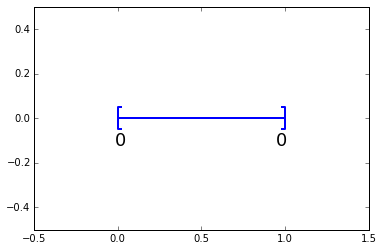

In [1]:
import pyLBM
import numpy as np
%matplotlib inline
xmin, xmax = 0., 1.
dico_geom = {
    'box': {'x': [xmin, xmax], 'label':0},
}
geom = pyLBM.Geometry(dico_geom)
print geom
geom.visualize(viewlabel=True)

###The stencil

pyLBM provides a class stencil that is used to define the discret velocities of the scheme. In this example, the stencil is composed by the velocities $v_0=0$, $v_1=1$ and $v_2=-1$ numbered by $[0,1,2]$.

####Question 2

Propose a dictionary for the stencil of these three velocities in dimension $1$. Visualize it with the viewer MatplotlibViewer in pyLBM.viewer.

Stencil informations
	 * spatial dimension: 1
	 * maximal velocity in each direction: [1 None None]
	 * minimal velocity in each direction: [-1 None None]
	 * Informations for each elementary stencil:
		stencil 0
		 - number of velocities:  3
		 - velocities: (0: 0), (1: 1), (2: -1), 



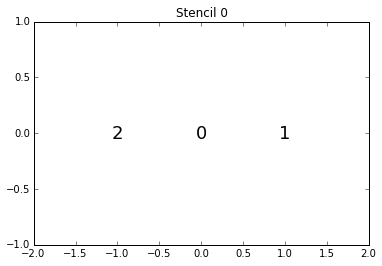

In [2]:
dico_sten = {
    'dim':1,
    'schemes':[{'velocities':[0,1,2]}],
}
sten = pyLBM.Stencil(dico_sten)
print sten
sten.visualize()

###The domain

In order to build the domain of the simulation, the dictionary should contain the space step $\dx$ and the stencils of the velocities (one for each scheme). 

####Question 3

Propose a dictionary for the domain with $N=10$ points in space. Visualize it.

Domain informations
	 spatial dimension: 1
	 bounds of the box: bounds = [[ 0.  1.]]
	 space step: dx= 1.000e-01



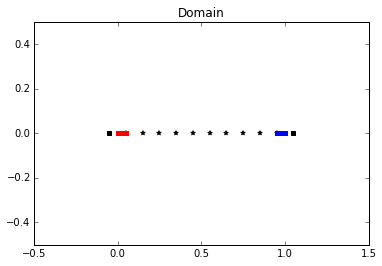

In [3]:
N = 10
dx = (xmax-xmin)/N
dico_dom = {
    'box': {'x': [xmin, xmax], 'label':0},
    'space_step':dx,
    'schemes':[
        {
            'velocities':[0,1,2],
        }
    ],
}
dom = pyLBM.Domain(dico_dom)
print dom
dom.visualize()

###The scheme

In pyLBM, a simulation can be performed by using several coupled schemes. In this example, a single scheme is used and defined through a list of one single dictionary. This dictionary should contain:

* 'velocities': a list of the velocities
* 'conserved_moments': a list of the conserved moments as sympy variables
* 'polynomials': a list of the polynomials that define the moments
* 'equilibrium': a list of the equilibrium value of all the moments
* 'relaxation_parameters': a list of the relaxation parameters ($0$ for the conserved moments)
* 'init': a dictionary to initialize the conserved moments

(see the documentation for more details)

####Question 4

Propose a dictionary for the scheme. The scheme velocity could be taken to $1/\dx$ and the inital value of $u$ to $0$ ('init':{u:$0$.}).

####Question 5

Modify the previous dictionary to impose the initial condition:
$$ u(t=0,x) = \sin(\pi x).$$

In [5]:
import sympy as sp

def solution(x, t):
    return np.sin(np.pi*x)*np.exp(-np.pi**2*mu*t)

# parameters
mu = 1.
la = 1./dx
s1 = 2./(1+2*mu)
s2 = 1.
u, X = sp.symbols('u, X')

dico_sch = {
    'dim':1,
    'scheme_velocity':la,
    'schemes':[
        {
            'velocities':range(3),
            'conserved_moments':u,
            'polynomials':[1, X, X**2/2],
            'equilibrium':[u, 0., .5*u],
            'relaxation_parameters':[0., s1, s2],
            'init':{u:(solution, (0.,))},
        }
    ],
}

sch = pyLBM.Scheme(dico_sch)
print sch

Scheme informations
	 spatial dimension: dim=1
	 number of schemes: nscheme=1
	 number of velocities:
    Stencil.nv[0]=3
	 velocities value:
    v[0]=(0: 0), (1: 1), (2: -1), 
	 polynomials:
    P[0]=Matrix([[1], [X], [X**2/2]])
	 equilibria:
    EQ[0]=Matrix([[u], [0.0], [0.5*u]])
	 relaxation parameters:
    s[0]=[0.0, 0.6666666666666666, 1.0]
	 moments matrices
M = [Matrix([
[1,   1,   1],
[0,   1,  -1],
[0, 1/2, 1/2]])]
invM = [Matrix([
[1,    0, -2],
[0,  1/2,  1],
[0, -1/2,  1]])]



###The simulation

A simulation is built by defining a correct dictionary.

####Question 6

Combine the previous dictionaries to build a simulation. In order to impose the homogeneous Dirichlet conditions in $x=0$ and $x=1$, the dictionary should contain the key 'boundary_conditions' (use pyLBM.bc.anti_bounce_back function).

In [6]:
dico = {
    'box':{'x':[xmin, xmax], 'label':0},
    'space_step':dx,
    'scheme_velocity':la,
    'schemes':[
        {
            'velocities':range(3),
            'conserved_moments':u,
            'polynomials':[1, X, X**2/2],
            'equilibrium':[u, 0., .5*u],
            'relaxation_parameters':[0., s1, s2],
            'init':{u:(solution,(0.,))},
        }
    ],
    'boundary_conditions':{
        0:{'method':{0:pyLBM.bc.anti_bounce_back,}, 'value':None},
    },
}

sol = pyLBM.Simulation(dico)
print sol

Simulation informations
Domain informations
	 spatial dimension: 1
	 bounds of the box: bounds = [[ 0.  1.]]
	 space step: dx= 1.000e-01
Scheme informations
	 spatial dimension: dim=1
	 number of schemes: nscheme=1
	 number of velocities:
    Stencil.nv[0]=3
	 velocities value:
    v[0]=(0: 0), (1: 1), (2: -1), 
	 polynomials:
    P[0]=Matrix([[1], [X], [X**2/2]])
	 equilibria:
    EQ[0]=Matrix([[u], [0.0], [0.5*u]])
	 relaxation parameters:
    s[0]=[0.0, 0.6666666666666666, 1.0]
	 moments matrices
M = [Matrix([
[1,   1,   1],
[0,   1,  -1],
[0, 1/2, 1/2]])]
invM = [Matrix([
[1,    0, -2],
[0,  1/2,  1],
[0, -1/2,  1]])]



##Run a simulation

Once the simulation is initialized, one time step can be performed by using the function one_time_step.

####Question 7

Compute the solution of the heat equation at $t=0.1$. On the same graphic, plot the initial condition, the exact solution and the numerical solution.

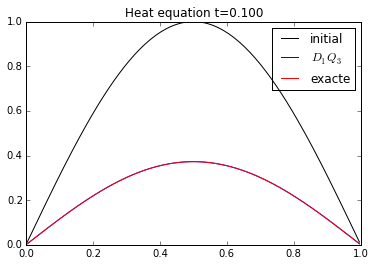

In [7]:
import numpy as np
import sympy as sp
import pylab as plt
import pyLBM

u, X = sp.symbols('u, X')

def solution(x, t):
    return np.sin(np.pi*x)*np.exp(-np.pi**2*mu*t)

xmin, xmax = 0., 1.
N = 128
mu = 1.
Tf = .1
dx = (xmax-xmin)/N # spatial step
la = 1./dx
s1 = 2./(1+2*mu)
s2 = 1.
dico = {
    'box':{'x':[xmin,xmax], 'label':0},
    'space_step':dx,
    'scheme_velocity':la,
    'schemes':[
        {
            'velocities':range(3),
            'conserved_moments':u,
            'polynomials':[1, X, X**2/2],
            'equilibrium':[u, 0., .5*u],
            'relaxation_parameters':[0., s1, s2],
            'init':{u:(solution,(0.,))},
        }
    ],
    'boundary_conditions':{
        0:{'method':{0:pyLBM.bc.anti_bounce_back,}, 'value':None},
    },
}

sol = pyLBM.Simulation(dico)
x = sol.domain.x[0][1:-1]
y = sol.m[0][0][1:-1]

plt.figure(1)
plt.hold(True)
plt.plot(x, y,'k', label='initial')

while sol.t < 0.1:
    sol.one_time_step()

plt.plot(x, y,'b', label=r'$D_1Q_3$')
plt.plot(x, solution(x, sol.t),'r', label='exacte')
plt.title('Heat equation t={0:5.3f}'.format(sol.t))
plt.legend()
plt.hold(False)

In [8]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./custom.css", "r").read()
    return HTML(styles)
css_styling()